<a href="https://colab.research.google.com/github/SDS-AAU/SDS-master/blob/master/M2/exercises/Poltweets_assignment_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picking liberal and conservative tweets

In this tutorial I will be guiding you to a type line of language processing in which we will take a label data set from one context, train a language model and apply it two slightly different context. And examples before you have seen sentiment analysis here's a case of supervised machine learning and language processing. Obviously, text can be classified across all kinds of dimensions and in this case we are going to look at political affiliation. 

In the following notebook we are going to train a language model to identify the political leaning of a tweet. We will use tweets from members of the US Congress well we know which political party did long too. This data set is there by our training data set as it is naturally labeled - in other words we can observe easily who sent off a tweet. the test data set contains 8000 tweets issued before the presidential debate in autumn 2020. our implicit assumption is that political leanings represented in the training data set and the language used there is similar to the new corpus. This assumption he's a potential cause for bias. Obviously, members of the Congress will not be using obvious derogatory language for instance. 

This notebook will first train a simple model using Sklearn. Then we will turn to more “manual” and controlled approaches with other packaging. 


### Loading the data and cleaning

In [52]:
import pandas as pd

In [53]:
# load labeled data
data = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz')

In [54]:
data

,text,labels
340675,RT @GreenBeretFound Today we remember Sgt. 1st...,0
289492,"Yes, yes, yes, yes and yes. 😷 #JerseyStrong 💪🏾...",1
371088,Made new friends this afternoon delivering mas...,1
82212,RT @TXMilitary Happening TODAY: Pilots with th...,0
476047,RT @SteveScalise President Trump's legal team ...,0
...,...,...
61499,Outrageous.\n\nBrave health care workers are p...,0
185562,RT @dskolnick .@RepTimRyan proposes up to $3K ...,1
354040,It is clear that the #HeroesAct will help tens...,1
708686,Democrats are talking about Bolton and Mulvane...,0


In [ ]:
# cleaning up twitter data
!pip install tweet-preprocessor

In [55]:
# cleaning up twitter data
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.MENTION)

In [56]:
p.clean('RT 🤬 this is a tweet #yeah @CBS http://something.dk')

'this is a tweet #yeah'

In [57]:
data['text_clean'] = [p.clean(tweet) for tweet in data['text']]

In [59]:
y = data['labels']

### Split data and train models in sklearn

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data['text_clean'], y, test_size=0.2, random_state=42)

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

In [63]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [ ]:
model.fit(X_train_vec, y_train)

In [65]:
X_test_vec = vectorizer.transform(X_test)

In [66]:
model.score(X_test_vec, y_test)

0.7912

In [67]:
model.predict(vectorizer.transform(['the media is corrupt']))

array([0])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline

vec = TfidfVectorizer(min_df=3, stop_words='english',
                      ngram_range=(1, 2))
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
lsa = make_pipeline(vec, svd)

clf = LogisticRegression()
pipe = make_pipeline(lsa, clf)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

In [ ]:
!pip install eli5

In [68]:
X_test

242366    "The U.S. must lead the world in developing an...
679874    I've been pushing FBI for transparency on Russ...
186087    We agree. Leaders lead. You can activate the D...
176019    Senate Dems stalling aid, economic stability f...
254260    Join me, , and State Rep. Carlos Gonzalez now ...
                                ...                        
728145    We are relieved that no American or Iraqi serv...
39849     Last month, the House Select Committee on the ...
615926    Just In: I talked to about the potential peace...
415010    ATTN: today is #Census Day. The census provide...
30607     21 Law enforcement officers shot in the last w...
Name: text_clean, Length: 10000, dtype: object

In [69]:
doc = X_test[176019]

In [70]:
doc

'Senate Dems stalling aid, economic stability for Americans. Why? Because Pelosi wants: Mandates on airlines to spend on carbon offsets, not workers Weaken voter laws for the 2020 election Corporate board diversity You cant make this stuff up.'

In [71]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=['rep','dem'])

In [72]:
eli5.show_prediction(model, doc, vec=vectorizer)

## Now a more manual approach to bootstrap a dictionary, find similar docs and explore topics

In [73]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
stop_words = set(stopwords.words('english'))
tknzr = TweetTokenizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
from sklearn.metrics import confusion_matrix

In [75]:
tokenized_simple = data['text_clean'].map(lambda row: [tok.lower() for tok in tknzr.tokenize(row) if tok not in stop_words and tok.isalpha()])

In [76]:
data['simple_tokens'] = tokenized_simple

In [77]:
# Import the dictionary builder
from gensim.corpora.dictionary import Dictionary

# Import the TfidfModel from Gensim
from gensim.models.tfidfmodel import TfidfModel

# Just like before, we import the model
from gensim.models.lsimodel import LsiModel

In [78]:
train_df = data[:40000]
test_df = data[40000:]

In [79]:
dictionary = Dictionary(train_df['simple_tokens'])

In [80]:
# Filter it for extreme stuff
dictionary.filter_extremes(no_below = 50, no_above=0.4, keep_n=1000)

In [81]:
# construct corpus using this dictionary
train_corpus = [dictionary.doc2bow(doc) for doc in train_df['simple_tokens']]
test_corpus = [dictionary.doc2bow(doc) for doc in test_df['simple_tokens']]

In [82]:
# Tooling to map between corpus (gensim) and matrix - more general
from gensim.matutils import corpus2csc, corpus2dense

In [83]:
tfidf = TfidfModel(train_corpus)

In [84]:

train_corpus_tfidf = tfidf[train_corpus]
test_corpus_tfidf = tfidf[test_corpus]

In [85]:
# Just like before, we import the model
from gensim.models.lsimodel import LsiModel

In [86]:
# Training the LSI model
model_lsi = LsiModel(train_corpus_tfidf, num_topics = 100, id2word=dictionary)

In [87]:
model_lsi.print_topics(10)

[(0,
  '0.214*"i" + 0.174*"the" + 0.151*"we" + 0.145*"qt" + 0.129*"need" + 0.126*"today" + 0.122*"health" + 0.118*"this" + 0.114*"people" + 0.112*"trump"'),
 (1,
  '0.299*"small" + 0.283*"businesses" + 0.221*"health" + 0.176*"workers" + 0.173*"help" + -0.169*"president" + 0.167*"care" + -0.157*"i" + 0.156*"need" + 0.149*"relief"'),
 (2,
  '-0.397*"thank" + 0.317*"trump" + 0.279*"the" + 0.261*"president" + -0.245*"i" + 0.152*"house" + -0.138*"day" + -0.138*"today" + -0.138*"happy" + 0.136*"senate"'),
 (3,
  '0.463*"health" + 0.364*"care" + -0.280*"small" + -0.249*"businesses" + 0.178*"we" + -0.167*"house" + -0.141*"the" + 0.140*"public" + 0.128*"thank" + -0.119*"senate"'),
 (4,
  '0.239*"thank" + -0.212*"live" + 0.210*"act" + -0.167*"covid" + -0.166*"join" + -0.163*"trump" + 0.156*"house" + -0.146*"de" + 0.142*"bill" + -0.127*"new"'),
 (5,
  '-0.502*"thank" + 0.286*"vote" + -0.266*"president" + -0.263*"trump" + 0.210*"we" + 0.135*"need" + 0.134*"today" + 0.130*"voting" + -0.127*"u" + 0.

In [88]:

train_corpus_lsi = model_lsi[train_corpus_tfidf]
test_corpus_lsi = model_lsi[test_corpus_tfidf]

In [89]:
# Load the MatrixSimilarity
from gensim.similarities import MatrixSimilarity

# Create the document-topic-matrix
document_topic_matrix_train = MatrixSimilarity(train_corpus_lsi)

# this will create you a document - document similarity matrix (you could import it as a network...)
document_topic_matrix_train_ix = document_topic_matrix_train.index

# Same for test-set
document_topic_matrix_test = MatrixSimilarity(test_corpus_lsi)
document_topic_matrix_test_ix = document_topic_matrix_test.index

In [90]:
# Prepare the query

doc = "Trump lies"


vec_bow = dictionary.doc2bow(doc.lower().split()) # convert to bag of words
vec_tfidf = tfidf[vec_bow] # convert to tfidf
vec_lsi = model_lsi[vec_tfidf]  # convert the query to LSI space

print(len(vec_lsi))
print(vec_lsi[:10])

100
[(0, 0.11226462861189736), (1, -0.13400545543091272), (2, 0.3169954603634245), (3, 0.09198700462963152), (4, -0.16323721117262133), (5, -0.26325404461921065), (6, 0.07564273361054197), (7, -0.10042807254447193), (8, 0.05967286540664475), (9, -0.18396837218314088)]


In [91]:
sims = document_topic_matrix_train[vec_lsi]

sims = sorted(enumerate(sims), key=lambda item: -item[1])
for i, s in sims[:10]: #ten most similar texts
    print(s, train_df.iloc[i,:]['text'])

1.0 Trump is ping ponging from platitudes to propaganda to downright bald-faced lies.
0.98955286 @CarolineEDavis3 Ma’am, the ratio was 105.3% when Trump came down the escalator.
0.986025 RT @MemphisHoller "Trump University, that wasn't even Trump Kindergartgen" @RepCohen 😂😂😂 http://pbs.twimg.com/tweet_video_thumb/EX1MNuBXgAs1seG.jpg https://video.twimg.com/tweet_video/EX1MNuBXgAs1seG.mp4
0.9843757 Trust me, my sister @KamalaHarris is not worried about Donald Trump. Donald Trump should be worried about Kamala Harris. http://pbs.twimg.com/amplify_video_thumb/1293363951896604673/img/UyG19VjEu6DozMN1.jpg https://video.twimg.com/amplify_video/1293363951896604673/vid/480x270/WoloYG5JFEF-7-nZ.mp4?tag=13
0.9833878 RT @MAS0424 @brianschatz Maybe when trump gives his speech
0.9640105 Vote-by-mail is not corrupt. But Donald Trump is. https://www.vox.com/policy-and-politics/2020/8/18/21373478/absentee-ballot-vote-by-mail-voting
0.95737743 Donald Trump is more interested in preserving monuments of 

### Use the previousely trained model on new tweets

In [92]:
new_tweets = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pres_debate_2020.gz')

In [93]:
new_tweets['tweet_clean'] = new_tweets['tweet'].map(p.clean)

In [95]:
X_new = vectorizer.transform(new_tweets['tweet_clean'])

In [96]:
X_new.shape

(8811, 40022)

In [97]:
new_tweets['prob_dem'] = model.predict_proba(X_new)[:,1]

In [98]:
pd.set_option('display.max_colwidth', 0)

In [99]:
new_tweets.sort_values('prob_dem', ascending=False)['tweet'][:10]

41      #PresidentialDebate2020   ? for Trump: @JoeBiden wills to lead for ALL Americans, so President Trump, what is it that you think your fans will desire of #BidenHarris2020 should they win the election?  #BidenHarris2020                                                                                       
8631    The climate crisis is urgent and we deserve to hear how the #PresidentialDebate2020 candidates will tackle it. @SusanPage please ask a #ClimateChange question at the #VPDebate ! #climate  https://t.co/9nRDAAKlFz                                                                                             
966     #4 Climate Change mr Trump why don’t you believe in science?  #5 National Security mr Trump why are you a Russian agent?   #6 Leadership mr trump why are you a reprobate?  #Debates2020 #PresidentialDebate2020                                                                                                
3675    This means that Donald Trump has already conceded def

In [100]:
new_tweets['mentions'] = new_tweets['tweet'].map(lambda tweet: [token for token in tknzr.tokenize(tweet) if token.startswith('@')])

In [101]:
new_tweets_mentions = new_tweets[new_tweets['mentions'].map(len) > 0]

In [102]:
import itertools
from collections import Counter

In [103]:
dem_tweets = new_tweets_mentions[new_tweets_mentions['prob_dem'] > 0.8]
rep_tweets = new_tweets_mentions[new_tweets_mentions['prob_dem'] < 0.3]

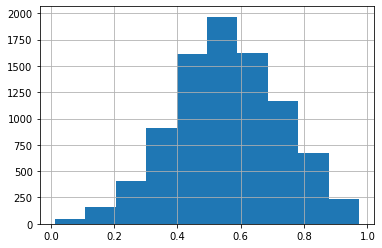

In [104]:
new_tweets.prob_dem.hist()

In [105]:
# Collect
dem_tags = itertools.chain(*dem_tweets['mentions'])
rep_tags = itertools.chain(*rep_tweets['mentions'])

In [106]:
counted_tags = Counter(dem_tags)
counted_tags.most_common()[:10]

[('@JoeBiden', 101),
 ('@realDonaldTrump', 87),
 ('@KamalaHarris', 19),
 ('@NBCNews', 12),
 ('@POTUS', 12),
 ('@VP', 10),
 ('@CNN', 7),
 ('@debates', 7),
 ('@ABC', 7),
 ('@', 4)]

In [107]:
counted_tags = Counter(rep_tags)
counted_tags.most_common()[:10]

[('@realDonaldTrump', 81),
 ('@JoeBiden', 47),
 ('@YouTube', 19),
 ('@POTUS', 11),
 ('@debates', 7),
 ('@KamalaHarris', 7),
 ('@FoxNews', 6),
 ('@seanhannity', 6),
 ('@Mike_Pence', 6),
 ('@VP', 6)]

In [108]:
all_tags = itertools.chain(*new_tweets['mentions'])

In [109]:
counted_tags = Counter(all_tags)
counted_tags.most_common()[:10]

[('@realDonaldTrump', 1155),
 ('@JoeBiden', 826),
 ('@KamalaHarris', 217),
 ('@POTUS', 162),
 ('@VP', 126),
 ('@debates', 90),
 ('@YouTube', 79),
 ('@NBCNews', 72),
 ('@Mike_Pence', 67),
 ('@CNN', 61)]